Generating Training Data (SNR=7dB, N=100000)...
Training XGBoost...
Training MLP (Cross-Entropy)...
Generating Large Test Set (N=500000) for smooth ROC...
Calculating Probabilities...


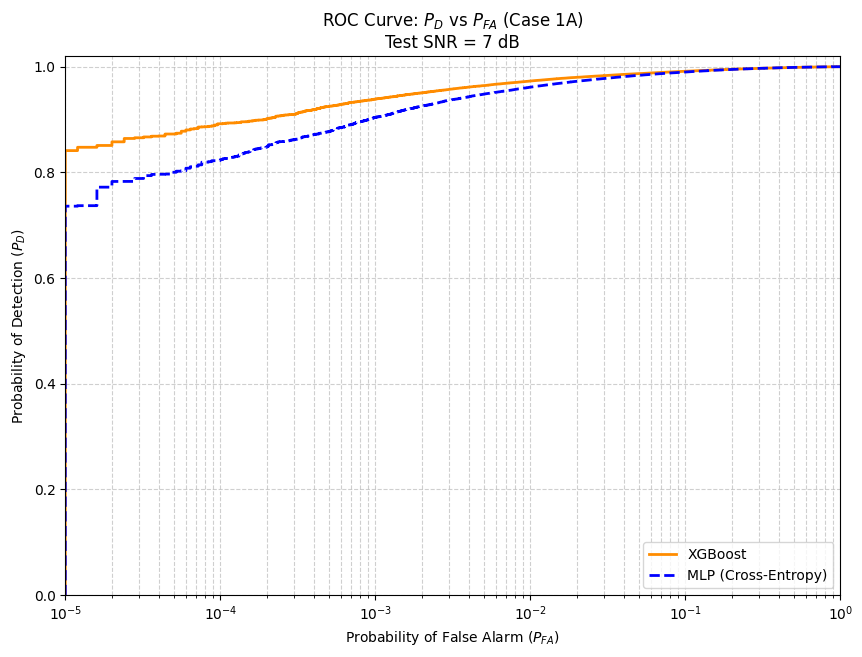

Comparison Complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# --- Configuration ---
L_complex = 8
L_real = 2 * L_complex
TRAIN_SNR_dB = 7
TEST_SNR_dB = 7
N_TRAIN = 100_000
N_TEST_ROC = 500_000   # Increased for better resolution at low PFA
noise_power = 1.0
MIN_PFA_PLOT = 1e-5    # The left limit of the plot x-axis

# --- Helper Functions ---

def generate_complex_gaussian(N_samples, Cov_matrix):
    L = Cov_matrix.shape[0]
    Re_C = Cov_matrix.real
    Im_C = Cov_matrix.imag
    Sigma = 0.5 * np.block([[Re_C, -Im_C], [Im_C, Re_C]])
    X_real = np.random.multivariate_normal(np.zeros(2 * L), Sigma, N_samples)
    Z_complex = X_real[:, :L] + 1j * X_real[:, L:]
    return Z_complex

def complex_to_real_inputs(Z_complex):
    N, L = Z_complex.shape
    X_real = np.zeros((N, 2 * L))
    X_real[:, ::2] = Z_complex.real
    X_real[:, 1::2] = Z_complex.imag
    return X_real

def generate_dataset_case1a(N_samples, snr_db, L_complex, noise_power):
    snr_linear = 10**(snr_db / 10.0)
    signal_power = snr_linear * noise_power
    C_noise = noise_power * np.identity(L_complex)

    # Split
    N_H0 = N_samples // 2
    N_H1 = N_samples - N_H0

    # H0
    Z_H0 = generate_complex_gaussian(N_H0, C_noise)
    X_H0 = complex_to_real_inputs(Z_H0)
    y_H0 = np.zeros(N_H0)

    # H1
    rho_t_samples = np.random.uniform(0, 1, N_H1)
    Z_H1 = np.zeros((N_H1, L_complex), dtype=complex)

    for i in range(N_H1):
        rho_t = rho_t_samples[i]
        indices = np.arange(L_complex)
        R_signal = rho_t**np.abs(indices[:, None] - indices[None, :])
        C_signal = signal_power * R_signal
        C_total = C_signal + C_noise
        Z_H1[i, :] = generate_complex_gaussian(1, C_total).flatten()

    X_H1 = complex_to_real_inputs(Z_H1)
    y_H1 = np.ones(N_H1)

    X = np.vstack([X_H0, X_H1])
    y = np.concatenate([y_H0, y_H1])
    idx = np.random.permutation(len(y))
    return X[idx], y[idx]

# --- Main Execution ---

# 1. Train
print(f"Generating Training Data (SNR={TRAIN_SNR_dB}dB, N={N_TRAIN})...")
X_train, y_train = generate_dataset_case1a(N_TRAIN, TRAIN_SNR_dB, L_complex, noise_power)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print("Training XGBoost...")
xgb = XGBClassifier(n_estimators=300, max_depth=8, learning_rate=0.05,
                    objective='binary:logistic', n_jobs=-1, random_state=42)
xgb.fit(X_train_scaled, y_train)

print("Training MLP (Cross-Entropy)...")
mlp = MLPClassifier(hidden_layer_sizes=(20,), activation='tanh', solver='adam',
                    max_iter=300, random_state=42)
mlp.fit(X_train_scaled, y_train)

# 2. Test
print(f"Generating Large Test Set (N={N_TEST_ROC}) for smooth ROC...")
X_test, y_test = generate_dataset_case1a(N_TEST_ROC, TEST_SNR_dB, L_complex, noise_power)
X_test_scaled = scaler.transform(X_test)

print("Calculating Probabilities...")
probs_xgb = xgb.predict_proba(X_test_scaled)[:, 1]
probs_mlp = mlp.predict_proba(X_test_scaled)[:, 1]

# 3. Calculate ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, probs_xgb)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, probs_mlp)

# --- PLOTTING FIX ---
# To ensure the plot visually starts at 0 at the left axis limit:
# We clamp all FPR values to MIN_PFA_PLOT. This handles cases where FPR is 0
# (which is undefined on log scale) by stacking them at the left edge.
# This visually creates a vertical line rising from 0 if the model is very good.

def apply_log_scale_fix(fpr, tpr, min_pfa):
    # 1. Clip all PFA values to be at least min_pfa
    fpr_clipped = np.maximum(fpr, min_pfa)

    # 2. Explicitly ensure the first point is at (min_pfa, 0)
    fpr_clipped[0] = min_pfa
    tpr[0] = 0.0

    return fpr_clipped, tpr

fpr_xgb, tpr_xgb = apply_log_scale_fix(fpr_xgb, tpr_xgb, MIN_PFA_PLOT)
fpr_mlp, tpr_mlp = apply_log_scale_fix(fpr_mlp, tpr_mlp, MIN_PFA_PLOT)

# --- Plot ---
plt.figure(figsize=(10, 7))

plt.semilogx(fpr_xgb, tpr_xgb, label='XGBoost', color='darkorange', linewidth=2)
plt.semilogx(fpr_mlp, tpr_mlp, label='MLP (Cross-Entropy)', color='blue', linestyle='--', linewidth=2)

plt.title(f'ROC Curve: $P_D$ vs $P_{{FA}}$ (Case 1A)\nTest SNR = {TEST_SNR_dB} dB')
plt.xlabel('Probability of False Alarm ($P_{FA}$)')
plt.ylabel('Probability of Detection ($P_D$)')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.xlim(MIN_PFA_PLOT, 1.0) # Set x-axis limit to match our start point
plt.ylim(0, 1.02)

plt.show()

print("Comparison Complete.")